In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm


In [2]:
class_names = ['anemic', 'Non-anemic']  
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (224, 224)

def load_data():
    """
    Load the data and split it into train, validation, and test sets.
    """
    dataset_dir ='C:/Users/seif/Downloads/3/Application of Machine Learning in Detecting Iron Deficiency Anemia Using  Conjunctiva image Dataset from Ghana'
    images = []
    labels = []

    print("Loading dataset...")
    
    for folder in os.listdir(dataset_dir):
        label = class_names_label[folder]
        
        for file in tqdm(os.listdir(os.path.join(dataset_dir, folder))):
            
            img_path = os.path.join(os.path.join(dataset_dir, folder), file)
            
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, IMAGE_SIZE) 
            
            images.append(image)
            labels.append(label)
                
    images = np.array(images, dtype='float32')
    labels = np.array(labels, dtype='int32')
    
    images, labels = shuffle(images, labels, random_state=25)
    
    # Splitting the data into 75% train, 10% validation, and 15% test
    split_1 = int(0.75 * len(images))
    split_2 = int(0.85 * len(images))
    
    train_images = images[:split_1]
    train_labels = labels[:split_1]
    
    val_images = images[split_1:split_2]
    val_labels = labels[split_1:split_2]
    
    test_images = images[split_2:]
    test_labels = labels[split_2:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

Loading dataset...


100%|██████████| 1686/1686 [00:03<00:00, 433.66it/s]


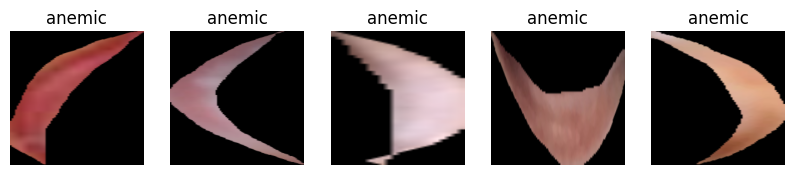

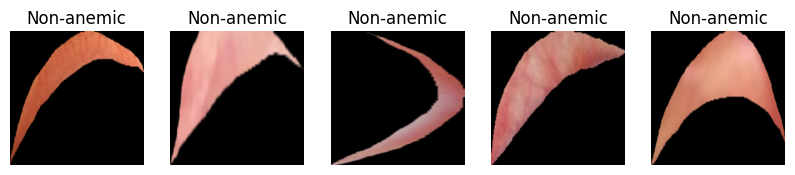

In [3]:
import matplotlib.pyplot as plt

def plot_class_images(images, labels, class_label, class_name, num_images=5):
    """
    Plots the first num_images images from the given class.
    """
    idxs = [i for i, label in enumerate(labels) if label == class_label][:num_images]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].astype('uint8'))
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Plot 5 images of class 'anemic' (label 0) and 5 images of class 'Non-anemic' (label 1)
plot_class_images(train_images, train_labels, class_label=0, class_name='anemic')
plot_class_images(train_images, train_labels, class_label=1, class_name='Non-anemic')


In [4]:
train_images = preprocess_input(train_images)
val_images = preprocess_input(val_images)
test_images = preprocess_input(test_images)

n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 3196
Number of validation examples: 426
Number of testing examples: 640
Each image is of size: (224, 224)


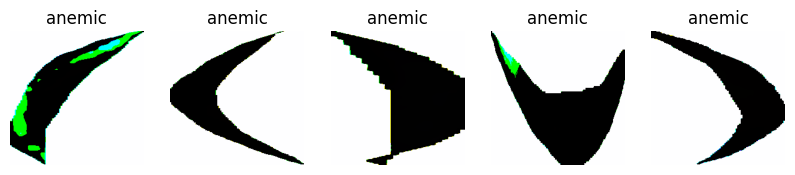

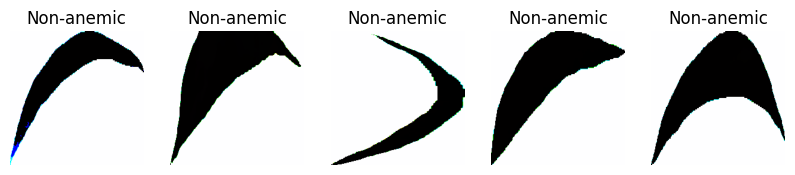

In [5]:
import matplotlib.pyplot as plt

def plot_class_images(images, labels, class_label, class_name, num_images=5):
    """
    Plots the first num_images images from the given class.
    """
    idxs = [i for i, label in enumerate(labels) if label == class_label][:num_images]
    
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(idxs):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[idx].astype('uint8'))
        plt.title(class_name)
        plt.axis('off')
    plt.show()

# Plot 5 images of class 'anemic' (label 0) and 5 images of class 'Non-anemic' (label 1)
plot_class_images(train_images, train_labels, class_label=0, class_name='anemic')
plot_class_images(train_images, train_labels, class_label=1, class_name='Non-anemic')


In [6]:
# Build the DenseNet121 model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2


base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-150:]:
    layer.trainable = True
    
    
# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu',kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x) 
 
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
predictions = Dense(1, activation='sigmoid')(x) 
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_densemodel.h5', monitor='val_accuracy', save_best_only=True, mode='max')



In [8]:
# Train the model
batch_size = 32
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=50,  
    validation_data=(val_images, val_labels),
    verbose=1,
    callbacks=[early_stopping, checkpoint])



Epoch 1/50
100/100 [==============================] - 375s 4s/step - loss: 1.7278 - accuracy: 0.6089 - val_loss: 1.4119 - val_accuracy: 0.7042
Epoch 2/50
100/100 [==============================] - 354s 4s/step - loss: 1.3005 - accuracy: 0.7547 - val_loss: 1.1087 - val_accuracy: 0.8521
Epoch 3/50
100/100 [==============================] - 355s 4s/step - loss: 1.0066 - accuracy: 0.8598 - val_loss: 0.9153 - val_accuracy: 0.9014
Epoch 4/50
100/100 [==============================] - 356s 4s/step - loss: 0.8170 - accuracy: 0.9227 - val_loss: 0.8339 - val_accuracy: 0.9108
Epoch 5/50
100/100 [==============================] - 360s 4s/step - loss: 0.6995 - accuracy: 0.9609 - val_loss: 0.8118 - val_accuracy: 0.9131
Epoch 6/50
100/100 [==============================] - 391s 4s/step - loss: 0.6451 - accuracy: 0.9725 - val_loss: 0.7087 - val_accuracy: 0.9437
Epoch 7/50
100/100 [==============================] - 359s 4s/step - loss: 0.6108 - accuracy: 0.9759 - val_loss: 0.7049 - val_accuracy: 0.9343

In [9]:
model.load_weights('best_densemodel.h5')
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.2%}")

20/20 [==============================] - 46s 2s/step - loss: 0.3762 - accuracy: 0.9688
Test Accuracy: 96.88%


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Predict probabilities
predictions = model.predict(test_images)

# Convert probabilities to binary labels (0 or 1)
predicted_labels = (predictions > 0.5).astype(int)

# Generate the classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))


20/20 [==============================] - 50s 2s/step
Classification Report:
              precision    recall  f1-score   support

      anemic       0.96      0.99      0.98       396
  Non-anemic       0.98      0.93      0.96       244

    accuracy                           0.97       640
   macro avg       0.97      0.96      0.97       640
weighted avg       0.97      0.97      0.97       640



In [11]:
precision = precision_score(test_labels, predicted_labels)
print(f'Precision: {precision}')

recall = recall_score(test_labels, predicted_labels)
print(f'Recall: {recall}')

f1 = f1_score(test_labels, predicted_labels)
print(f'F1 Score: {f1}')

Precision: 0.9827586206896551
Recall: 0.9344262295081968
F1 Score: 0.9579831932773109


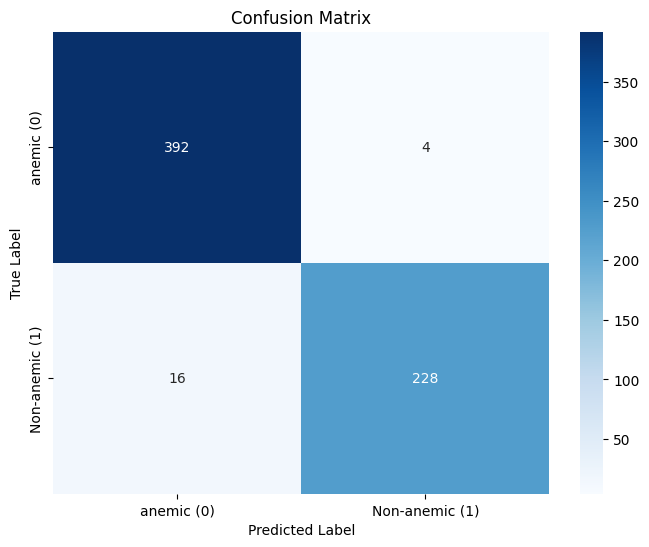

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Define class names with the correct labels
class_names = ['anemic (0)', 'Non-anemic (1)']

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [13]:
model.save('conjectiva_densenet.h5')